In [1]:
#Libraries to be install
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

In [2]:
class Node:
    def __init__(self, label):
        self.label = label

class Edge:
    def __init__(self, parent, child, label):
        self.parent = parent
        self.child = child
        self.label = label

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softplus(x):
    return np.log1p(np.exp(x))

def cross_entropy(output, label):
    epsilon = 1e-7
    output = np.clip(output, epsilon, 1 - epsilon)
    return -np.sum(label * np.log(output) + (1 - label) * np.log(1 - output))

def mse(output, label):
    return 0.5 * np.sum((output - label) ** 2)

In [4]:
class NeuralNetwork:
    def __init__(self, num_input, num_hidden, num_output, act_func, loss_func, bias):
        self.act_func = act_func
        self.loss_func = loss_func
        self.bias = bias
        self.inputs = [0] * num_input  # Initialize self.inputs with zeros

        # Initialize weights and biases
        self.weights = [np.random.uniform(-1, 1, (num_input, num_hidden[0]))]
        self.biases = [np.random.uniform(-1, 1, num_hidden[0])]
        for i in range(1, len(num_hidden)):
            self.weights.append(np.random.uniform(-1, 1, (num_hidden[i-1], num_hidden[i])))
            self.biases.append(np.random.uniform(-1, 1, num_hidden[i]))
        self.weights.append(np.random.uniform(-1, 1, (num_hidden[-1], num_output)))
        self.biases.append(np.random.uniform(-1, 1, num_output))

    def predict(self, inputs):
        activations = self.forward_prop(inputs)
        output = activations[-1]
        return output

    def forward_prop(self, inputs):
        self.activations = [inputs]
        for w, b in zip(self.weights, self.biases):
            inputs = np.dot(inputs, w) + b
            if self.act_func =='relu':
                inputs = np.clip(inputs, -10, 10)
                inputs = np.maximum(0, inputs)
            elif self.act_func =='sigmoid':
                inputs = sigmoid(inputs)
            elif self.act_func =='softplus':
                inputs = np.log(np.exp(np.clip(inputs, -10, 10)) + 1)
            self.activations.append(inputs)
        return self.activations

    def back_prop(self, inputs, labels):
        activations = self.forward_prop(inputs)
        output = activations[-1]

        # Calculate loss
        if self.loss_func == 'CrossEntropy':
            loss = cross_entropy(output, labels)
        elif self.loss_func =='mse':
            loss = mse(output, labels)
        else:
            raise ValueError("Invalid loss function. It should be 'cross_entropy' or'mse'.")

        # Backpropagation
        d_output = output - labels if self.loss_func == 'CrossEntropy' else 2 * (output - labels)
        d_weights = []
        d_biases = []
        for i in range(len(self.weights) - 1, -1, -1):
            if self.act_func =='sigmoid':
                d_output *= sigmoid(activations[i+1]) * (1 - sigmoid(activations[i+1]))
            elif self.act_func =='relu':
                d_output *= (activations[i+1] > 0).astype(int)
            elif self.act_func =='softplus':
                d_output *= (1 / (1 + np.exp(-activations[i+1])))

            d_weights.append(np.dot(np.array(activations[i]).T, d_output))
            d_biases.append(np.sum(d_output, axis=0, keepdims=True))
            d_output = np.dot(d_output, self.weights[i].T)

        return d_weights, d_biases, loss

    def train(self, inputs, labels, learning_rate, epochs):
            self.inputs = inputs  # Update self.inputs with the actual input values
            loss_values = []

            # Initialize Adam optimization variables
            m_weights = [np.zeros_like(w) for w in self.weights]
            v_weights = [np.zeros_like(w) for w in self.weights]
            m_biases = [np.zeros_like(b) for b in self.biases]
            v_biases = [np.zeros_like(b) for b in self.biases]

            beta1 = 0.9
            beta2 = 0.999
            epsilon = 1e-8

            for epoch in range(epochs):
                d_weights, d_biases, loss = self.back_prop(inputs, labels)
                loss_values.append(loss)

                # Update Adam optimization variables
                for i in range(len(self.weights)):
                    m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * d_weights[len(self.weights) - 1 - i]
                    v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * d_weights[len(self.weights) - 1 - i]**2
                    m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * d_biases[len(self.weights) - 1 - i]
                    v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * d_biases[len(self.weights) - 1 - i]**2

                    # Update weights and biases
                    self.weights[i] -= learning_rate * m_weights[i] / (np.sqrt(v_weights[i]) + epsilon)
                    self.biases[i] -= learning_rate * (m_biases[i] / (np.sqrt(v_biases[i]) + epsilon)).reshape(self.biases[i].shape)

                print(f"Loss at epoch {epoch}: {loss}")

            # Plot the training loss
            plt.plot(loss_values, label='Training Loss')
            plt.title('Training Loss Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

    def trace(self):
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR', 'nodesep': '0.1', 'ranksep': '0.5'})  
        nodes = []
        edges = []

        # Add input nodes
        with dot.subgraph() as s:
            s.attr(rank='same')
            for i in range(self.weights[0].shape[0]):
                node = Node(f"Input {i}")
                nodes.append(node)
                dot.node(name=str(id(node)), label=node.label, shape='circle')

        # Add hidden nodes
        hidden_nodes = []
        for i, w in enumerate(self.weights):
            if i < len(self.weights) - 1:
                with dot.subgraph() as s:
                    s.attr(rank='same')
                    hidden_layer = []
                    for j in range(w.shape[1]):
                        node = Node(f"Hidden {i} {j}")
                        nodes.append(node)
                        dot.node(name=str(id(node)), label=node.label, shape='circle')
                        hidden_layer.append(node)
                    hidden_nodes.append(hidden_layer)

        # Add output nodes
        with dot.subgraph() as s:
            s.attr(rank='same')
            output_nodes = []
            for i in range(self.weights[-1].shape[1]):
                node = Node(f"Output {i}")
                nodes.append(node)
                dot.node(name=str(id(node)), label=node.label, shape='circle')
                output_nodes.append(node)

        # Add edges
        for i, w in enumerate(self.weights):
            if i == 0:  # Input to hidden
                for j in range(w.shape[0]):
                    for k in range(w.shape[1]):
                        edge = Edge(nodes[j], hidden_nodes[0][k], f"Weight {i} {j} {k}\nValue: {w[j, k]:.2f}")
                        edges.append(edge)
                        dot.edge(str(id(edge.parent)), str(id(edge.child)), label=edge.label)
            elif i == len(self.weights) - 1:  # Hidden to output
                for j in range(w.shape[0]):
                    for k in range(w.shape[1]):
                        edge = Edge(hidden_nodes[-1][j], output_nodes[k], f"Weight {i} {j} {k}\nValue: {w[j, k]:.2f}")
                        edges.append(edge)
                        dot.edge(str(id(edge.parent)), str(id(edge.child)), label=edge.label)
            else:  # Hidden to hidden
                for j in range(w.shape[0]):
                    for k in range(w.shape[1]):
                        edge = Edge(hidden_nodes[i-1][j], hidden_nodes[i][k], f"Weight {i} {j} {k}\nValue: {w[j, k]:.2f}")
                        edges.append(edge)
                        dot.edge(str(id(edge.parent)), str(id(edge.child)), label=edge.label)

        return nodes, edges, dot

    def draw_dot(self):
        nodes, edges, dot = self.trace()
        return dot

Loss at epoch 0: 18.769672308924697
Loss at epoch 1: 3.031422596089242
Loss at epoch 2: 3.3850780975415717
Loss at epoch 3: 3.4018242184357312
Loss at epoch 4: 3.2654192971940854
Loss at epoch 5: 3.081131260586205
Loss at epoch 6: 2.8960327423288543
Loss at epoch 7: 2.781882311945414
Loss at epoch 8: 2.806927509124262
Loss at epoch 9: 2.9686769536054154
Loss at epoch 10: 3.1281261457864407
Loss at epoch 11: 3.121813224510489
Loss at epoch 12: 2.9791766886258833
Loss at epoch 13: 2.8340686979080276
Loss at epoch 14: 2.73936526617724
Loss at epoch 15: 2.740242830791232
Loss at epoch 16: 3.056458984334183
Loss at epoch 17: 3.4781145058386103
Loss at epoch 18: 3.484258460816904
Loss at epoch 19: 3.1462038839103568
Loss at epoch 20: 2.834407816300872
Loss at epoch 21: 2.769947209359785
Loss at epoch 22: 2.9484584115477595
Loss at epoch 23: 3.178071713672245
Loss at epoch 24: 3.2174917257681965
Loss at epoch 25: 3.05526745153438
Loss at epoch 26: 2.866453252944609
Loss at epoch 27: 2.7662310

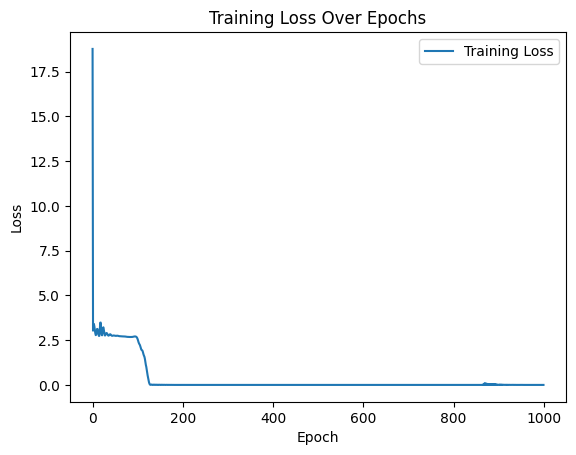

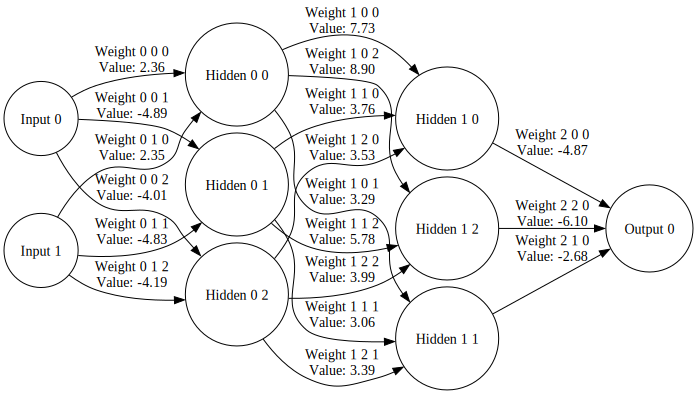

In [6]:
NN = NeuralNetwork(2, [3, 3], 1, "softplus", "CrossEntropy", 0.01)
inputs = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
labels = np.array([[0], [1], [1], [0]])
r = 0.1
epochs = 1000
NN.train(inputs, labels, r, epochs)
NN.draw_dot()

In [8]:
inputs = np.array([[0, 1]])

# Make predictions
predictions = NN.predict(inputs)
print(predictions)

[[0.99999357]]
